In [27]:
# Imports
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image as img
import math
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import linregress
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.signal import find_peaks





In [3]:

BRYGGE_SEKVENS = "./bilder/brygge_sekvens"
BRO_SEKVENS = "./bilder/bro_sekvens"
LAGRA_BILDER = ".bilder/lagra_bilete"
BLANDA_SEKVENS = "./bilder/blanda_sekvens"
RESULT_FOLDER = BRYGGE_SEKVENS

K = np.loadtxt(f"{RESULT_FOLDER}/left/K_matrix.txt")
R = np.loadtxt(f"{RESULT_FOLDER}/left/R_matrix.txt")
T = np.loadtxt(f"{RESULT_FOLDER}/left/T_matrix.txt")

plt.ion()

# Under åpner vi ti = n'te bildet
left_images_filenames = list(filter(lambda fn: fn.split(".")[-1]=="png", os.listdir(f"{RESULT_FOLDER}/left")))
timestamps = list(map(lambda fn: fn.split(".")[0], left_images_filenames))
ti = 0
timestamp = timestamps[ti]
left = cv2.imread(f"{RESULT_FOLDER}/left/{timestamp}.png")
right = cv2.imread(f"{RESULT_FOLDER}/right/{timestamp}.png")
disp = np.array(cv2.imread(f"{RESULT_FOLDER}/disp_zed/{timestamp}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)

print("Første:" ,timestamps[0], " Nærme: ", timestamps[len(timestamps)-1])

def fetch_image(main_as_well=False, RES_FOLDER=RESULT_FOLDER, time=timestamp):

    plt.ion()
    new_main_image = cv2.imread(f"{RES_FOLDER}/left/{time}.png")
    new_main_image = cv2.cvtColor(new_main_image, cv2.COLOR_BGR2RGB)
    new_disparity_image = np.array(cv2.imread(f"{RES_FOLDER}/disp_zed/{time}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)
    if(main_as_well):
        return new_disparity_image, new_main_image
    return new_disparity_image

def display_disp_image(to_be_displayed, title="Image", d_type="turbo"):
    plt.figure(figsize=(10, 6))
    plt.imshow(to_be_displayed, cmap=d_type)
    plt.title(title)
    plt.show()

def display_columns_on_image(input_image, col_indices=[500]):
    to_be_displayed = input_image.copy()
    colours = [(255,0,0), (0,255,0), (0,0,255)]
    height = to_be_displayed.shape[0]
    width = to_be_displayed.shape[1]

    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]

        to_be_displayed = cv2.line(to_be_displayed, (col_indices[index],0), (col_indices[index], height), colour, 3)
        #original_image = cv2.line(original_image, dimStart, dimSlutt, colour, 1)


    display_disp_image(to_be_displayed)


# Timestamps
# Første: 1689072599961543541  Nærme:  1689072633388130541 Bru:  1689068851836122093 Båt: 1689068854381001093
Første= 1689072599961543541  
Nærme=  1689072633388130541
Båt =  1689068854381001093
# Fra blanda
KajakkOgBåt = 1689068879500907093
BåtBak = 1689068856993399093
BåtFram = 1689068871596675093
BaderingMann = 1689072623607882541
Badering = 1689072630042776541

 

# Fetch a new current working image and respective disparity
# Dette er disp_første og venstre_første
#current_working_disparity, current_working_image = fetch_image(True)

# Dette er disp_nærme_brygga og nærme_brygga
første_disparity, første_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS ,time=Første)
nærme_disparity, nærme_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS, time=Nærme)
båt_disparity, båt_image = fetch_image(True, RES_FOLDER=BRO_SEKVENS, time=Båt)
kajakk_båt_disparity, kajakk_båt_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=KajakkOgBåt)
båt_bak_disparity, båt_bak_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtBak)
båt_fram_disparity, båt_fram_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtFram)
badering_første_disparity, badering_første_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=Badering)
badering_mann_disparity, badering_mann_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BaderingMann)

standard_fig_size = (10, 6)


Første: 1689072633388130541  Nærme:  1689072600363349541


In [4]:

def interpolate_column(column):
    # Indices of valid and invalid elements
    # Adds the indices of values that are valid meaning real numbers to valid_indices and invalid indices meaning inf, -inf and NaN to 
    valid_mask = np.isfinite(column)
    valid_indices = np.where(valid_mask)[0]
    invalid_indices = np.where(~valid_mask)[0]

    # Check if we have enough data for interpolation
    if len(valid_indices) == 0:
        # No valid data in this column
        return column
    elif len(invalid_indices) == 0:
        # No need for interpolation
        return column

    # Interpolate invalid data points
    valid_data = column[valid_mask]
    column[~valid_mask] = np.interp(invalid_indices, valid_indices, valid_data)
    return column

def interpolate_each_column(input):
    dI = input.copy()
    # Applying the interpolation to each column
    height, width = dI.shape
    for x in range(width):
        dI[:, x] = interpolate_column(dI[:, x])
    return dI

import matplotlib.colors as mcolors

def generate_dark_colors(n):
    # Define the saturation and value for dark colors
    saturation = 1.0  # full saturation for vivid colors
    value = 0.6  # dark enough to ensure good contrast on a white background
    
    # Generate colors
    colors = []
    for i in range(n):
        hue = i / n  # Evenly space hues around the color wheel
        rgb = mcolors.hsv_to_rgb((hue, saturation, value))
        colors.append(rgb)
    
    return colors

def disparity_graphing(disp_map, col_indices=[500], display=False, invert=False):
    
    colours = ['red', 'green', 'blue']

    plt.figure(figsize=standard_fig_size)
    # Extract and plot each column


    for i, col in enumerate(col_indices):
            if(col > disp_map.shape[1]):
                col_indices.pop(i+1)

    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]
        col_data = disp_map[:, col_idx]
        y_values = range(len(col_data))
        plt.plot(col_data, y_values, label=f'Column {index + 1} (Index {col_idx})', color=colour)


    title="Disparity profiles along Column(s) " + str(col_indices)

    # Invert y-axis to match image orientation
    if(invert):
        plt.gca().invert_yaxis()

    # Add labels and legend
    plt.xlabel('Disparity Value')
    plt.ylabel('V-value (rows)')
    plt.title(title)
    plt.legend()

    # Show the plot
    if(display):
        plt.show()

def display_columns_on_image(original_image, col_indices=[500]):
    colours = [(255,0,0), (0,255,0), (0,0,255)]
    height = original_image.shape[0]
    width = original_image.shape[1]

    og_image = original_image.copy()

    for i, col in enumerate(col_indices):
            if(col > og_image.shape[1]):
                print("Cols popped")
                col_indices.pop(i+1)

    title="Columns on original image"


    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]

        og_image = cv2.line(og_image, (col_indices[index],0), (col_indices[index], height), colour, 3)


    display_disp_image(og_image)

def display_columns_on_image_V2(original_image, col_indices=[500]):
    # Use a copy of the original image to draw on
    og_image = original_image.copy()
    height = og_image.shape[0]
    width = og_image.shape[1]

    title = "Columns on Original Image"

    # Iterate over each column index you want to display
    for col_idx in col_indices:
        if col_idx >= width:
            print("Column index out of image bounds:", col_idx)
            continue

        # Iterate over each pixel in the specified column
        for row in range(height):
            # Calculate the brightness of the current pixel
            pixel = og_image[row, col_idx]
            brightness = 0.299 * pixel[0] + 0.587 * pixel[1] + 0.114 * pixel[2]

            # Choose the line color based on the pixel brightness
            if brightness < 128:  # Dark pixel, make the line white
                line_color = (255, 255, 255)
            else:  # Light pixel, make the line black
                line_color = (0, 0, 0)

            # Set the pixel color on the image
            og_image[row, col_idx] = line_color

    # Display the modified image
    display_disp_image(og_image, title=title)


In [5]:
""" current_disparity_data = nærme_disparity.copy()
current_image = nærme_image.copy()
interpolate_each_column(current_disparity_data)
display_disp_image(current_image, "Original Image")
#display_disp_image(current_disparity_data, "Interpolated Disparity Image") """

' current_disparity_data = nærme_disparity.copy()\ncurrent_image = nærme_image.copy()\ninterpolate_each_column(current_disparity_data)\ndisplay_disp_image(current_image, "Original Image")\n#display_disp_image(current_disparity_data, "Interpolated Disparity Image") '

In [6]:
plot_initial_images = False
testing_image = False

if(testing_image):
    # Testing image
    current_original_image = nærme_image
    current_disparity_data = nærme_disparity
    curr_col = [1250]
    display_columns_on_image(current_original_image, curr_col)
    display_columns_on_image_V2(current_original_image, curr_col)
    disparity_graphing(current_disparity_data, curr_col, display=True, invert=True)
 


if(plot_initial_images):

    
    # Nærme
    print("Nærme")
    #cols_nærme = [730, 1215, 1483]
    cols_nærme = [730, 1215]
    display_columns_on_image(nærme_image, cols_nærme)
    disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=False)
    disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=True)


    # Første
    print("Første")
    #cols_første = [550, 1140, 1810]
    cols_første = [550, 1140]
    display_columns_on_image(første_image, cols_første)
    disparity_graphing(første_disparity, cols_første, display=True, invert=False)
    disparity_graphing(første_disparity, cols_første, display=True, invert=True)


    # Badering
    print("Badering")
    #cols_badering = [250, 1050, 186]
    cols_badering = [250, 1050]
    display_columns_on_image(badering_første_image, cols_badering)
    disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=False)
    disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=True)

    # Mann
    print("Mann")
    #cols_mann = [620, 1100, 1880]
    cols_mann = [620, 1100]
    display_columns_on_image(badering_mann_image, cols_mann)
    disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=False)
    disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=True)

    # Båt
    print("Båt")
    #cols_båt = [340, 585, 800]
    cols_båt = [585, 800]
    display_columns_on_image(båt_image, cols_båt)
    disparity_graphing(båt_disparity, cols_båt, display=True, invert=False)
    disparity_graphing(båt_disparity, cols_båt, display=True, invert=True)

    # BåtKajakk
    print("BåtKajakk")
    #cols_båtKajakk = [280, 1030, 1250]
    cols_båtKajakk = [280, 1030]
    display_columns_on_image(kajakk_båt_image, cols_båtKajakk)
    disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=False)
    disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=True)
    
    
    # BåtBak
    print("BåtBak")
    #cols_båtBak = [1100, 1250, 1500]
    cols_båtBak = [1100, 1250]
    display_columns_on_image(båt_bak_image, cols_båtBak)
    disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=False)
    disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=True)

    # BåtFram
    print("BåtFram")
    #cols_båtFram = [500, 600, 1250]
    cols_båtFram = [500, 600]
    display_columns_on_image(båt_fram_image, cols_båtFram)
    disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=False)
    disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=True)

#dI = båt_disparity
#original_image = båt_image

#dI = første_disparity
#original_image = første_image

dI = nærme_disparity
original_image = nærme_image

#dI = kajakk_båt_disparity
#original_image = kajakk_båt_image

#dI = båt_bak_disparity
#original_image = båt_bak_image

#dI = båt_fram_disparity
#original_image = båt_fram_image

#dI = badering_første_disparity
#original_image = badering_første_image

#dI = badering_mann_disparity
#original_image = badering_mann_image




In [7]:
from scipy.special import binom

n = 30  # Length of the kernel
kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
kernel_binomial = kernel_binomial / np.sum(kernel_binomial) 

# Function to apply low-pass filter to a column
def low_pass_filter(column, K=kernel_binomial):
    # Apply convolution
    filtered_column = np.convolve(column, K, mode='same')
    return filtered_column

# Input should be a disparity image where each column is differentiated
def flatten_and_plot_histogram(df_derivative, plot=True,title="Histogram of Derivative Values", input_bins=2000):
    # Flatten the array of derivatives to a 1D array
    flattened_derivatives = df_derivative.flatten()

    if(plot):
        # Plot the histogram
        plt.figure()
        plt.hist(flattened_derivatives, bins=input_bins, range=(-0.2,0.3), color='blue', edgecolor='blue')
        plt.title(title)
        plt.xlabel('Derivative Value')
        plt.ylabel('Frequency')
        # Show the plot
        plt.show()
    
    return flattened_derivatives

def apply_low_pass_filter(dI, K=kernel_binomial):
    
    height, width = dI.shape
    df = np.zeros_like(dI)  # Low-pass filtered disparity image
    for x in range(width):
        df[:, x] = low_pass_filter(dI[:, x], K=kernel_binomial)

    return df

def take_derivative_diff(df):
    print("Diff method")

    # Computing the derivative of each column
    df_derivative = np.diff(df, axis=0)

    # Padding to handle size difference after np.diff
    df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge')

    return df_derivative



def take_derivative_sobel(df, normalize=True):
    print("Sobel method")  

    # Define the 1D Sobel kernelS
    kernel_m = np.array([1, 0, -1])

    # Initialize an array to store the vertical derivative image
    vertical_derivative = np.zeros_like(df)

    # Apply the Sobel kernel to each column
    if(normalize):
        for i in range(df.shape[1]):  # Iterate over columns
            vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same') / 2 
    else:
        for i in range(df.shape[1]):  # Iterate over columns
            vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same')

    return vertical_derivative


## Clustering
def clustering(flattened_derivatives, a_mini=-0.3, a_maxi=0.5, clusters=2):
    # Clipping the data to be between -0.3 and 0.5
    clipped_derivatives = np.clip(flattened_derivatives, a_min=a_mini, a_max=a_maxi)

    clipped_derivatives = clipped_derivatives[(clipped_derivatives > a_mini) & (clipped_derivatives < a_maxi)]
    # Reshape data for KMeans
    clustering_model = clipped_derivatives.reshape(-1, 1)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init='auto')
    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return clustering_model, clipped_derivatives, labels, centers

def plot_clusters(clustering_model, labels):
    cluster1 = clustering_model[labels == 0]
    cluster2 = clustering_model[labels == 1]

    plt.figure()
    plt.hist(cluster1, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Cluster 1')
    plt.legend()
    plt.show()

    # Plot histogram 
    plt.figure()
    plt.hist(cluster2, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Cluster 2')
    plt.legend()
    plt.show()

    plt.figure()
    plt.hist(clustering_model, bins=200, range=(-0.2, 0.4), density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of both clusters')
    plt.legend()
    plt.show()

# Gaussian fit function
def fit_gaussian(data):
    mean = np.mean(data)
    stddev = np.std(data)
    return mean, stddev

def fit_clusters(clustering_model, labels):
    cluster1 = clustering_model[labels == 0]
    cluster2 = clustering_model[labels == 1]
    mean1, stddev1 = fit_gaussian(cluster1)
    mean2, stddev2 = fit_gaussian(cluster2)

    return mean1, mean2, stddev1, stddev2

def gaussian_curve(x, mean, stddev):
    return (1 / (stddev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / stddev) ** 2)


def cluster_threshold_method(clustering_model, labels, clipped_derivatives, k=1, plot=True):
    mean1, mean2, stddev1, stddev2 = fit_clusters(clustering_model, labels)
    # Determine which mean is closer to 0 and assign labels
    if abs(mean1) < abs(mean2):
        red_mean, green_mean = mean1, mean2
        red_stddev, green_stddev = stddev1, stddev2
        red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
    else:
        red_mean, green_mean = mean2, mean1
        red_stddev, green_stddev = stddev2, stddev1
        red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'


    red_dL = red_mean - k * red_stddev
    red_dU = red_mean + k * red_stddev
    green_dL = green_mean - k * green_stddev
    green_dU = green_mean + k * green_stddev

    if(plot):
        # Create a range of x values
        x_values = np.linspace(-0.25, 0.45, 400)

        # Gaussian curves
        gaussian_curve1 = gaussian_curve(x_values, mean1, stddev1)
        gaussian_curve2 = gaussian_curve(x_values, mean2, stddev2)

        # Plot histogram and Gaussian curves
        plt.figure(figsize=(10, 6))
        plt.hist(clipped_derivatives, bins=400, range=(-0.25, 0.45), density=True, alpha=0.6)
        plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
        plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
        plt.xlabel('Derivative Values')
        plt.ylabel('Frequency')
        plt.title('Histogram with Fitted Gaussian Curves')
        plt.legend()
        plt.show()
        
    return red_dL, red_dU, green_dL, green_dU


def thresholds_3_gaussians(flattened_derivatives, min_clip=-0.3, max_clip = 0.5, bins = 200, plot=True, k=2):
    num_curves = 3

    # Example flattened_derivatives - replace with your actual data
    # flattened_derivatives = ...

    # Clip the data between -0.3 and 0.6
    clipped_derivatives = np.clip(flattened_derivatives, min_clip, max_clip)

    # Removing extreme values
    filtered_data = clipped_derivatives[(clipped_derivatives > min_clip) & (clipped_derivatives < max_clip)]
    clipped_derivatives = filtered_data

    # Fit a Gaussian Mixture Model with 2 components to the data
    gmm = GaussianMixture(n_components=num_curves, random_state=0)
    #gmm = GaussianMixture(n_components=2, random_state=0, init_params='kmeans++')

    gmm.fit(clipped_derivatives.reshape(-1, 1))

    # Extract the means, covariances, and weights of the two Gaussians
    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    std_devs = np.sqrt(covariances)
    weights = gmm.weights_.flatten()

    if(plot):
        # Create a range of x values for plotting
        x_values = np.linspace(min_clip, max_clip, 400)
        # Calculate the individual Gaussians' PDFs
        gaussian_pdfs = [
            weights[i] * norm.pdf(x_values, means[i], np.sqrt(covariances[i]))
            for i in range(2)
        ]

        # Plot the histogram of the clipped data
        plt.figure(figsize=(10, 6))
        plt.hist(clipped_derivatives, bins=bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='g', label='Data Histogram')

        # Plot each Gaussian PDF
        for i, pdf in enumerate(gaussian_pdfs):
            plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means[i]:.2f}, SD: {np.sqrt(covariances[i]):.2f})')

        plt.legend()
        plt.title('Histogram with Individual Fitted Gaussian Distributions')
        plt.xlabel('Data Value')
        plt.ylabel('Density')

        plt.show()
    
    mean1 = means[0]
    mean2 = means[1]
    stddev1 = std_devs[0]
    stddev2 = std_devs[1]

    # Determine which mean is closer to 0 and assign labels
    if abs(mean1) < abs(mean2):
        red_mean, green_mean = mean1, mean2
        red_stddev, green_stddev = stddev1, stddev2
        red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
    else:
        red_mean, green_mean = mean2, mean1
        red_stddev, green_stddev = stddev2, stddev1
        red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'

    # Below are the upper and lower bounds
    # Assuming you have mean1, stddev1, mean2, stddev2 from the Gaussian fits


    red_dL = red_mean - k * red_stddev
    red_dU = red_mean + k * red_stddev
    green_dL = green_mean - k * green_stddev
    green_dU = green_mean + k * green_stddev


    return red_dL, red_dU, green_dL, green_dU

def thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=2, num_bins=200,p=0.01, k=2, plot=True, version=1):
    print("Thresholds Clipping verstion")

    clipped_derivatives = np.clip(flattened_derivatives, min_clip, max_clip)
    clipped_derivatives = clipped_derivatives[(clipped_derivatives > min_clip) & (clipped_derivatives < max_clip)]

    hist_values, bin_edges = np.histogram(clipped_derivatives, bins=num_bins, density=True)
    max_frequency = np.max(hist_values)
    threshold = p * max_frequency
    if(plot):
        print("Maximum frequency in the histogram:", max_frequency)
        print(f"Threshold ({p*100}% of max frequency):", threshold)

    # Adjust histogram values: set values below the threshold to 0
    smooth_hist_values = np.where(hist_values < threshold, 0, hist_values)

    if(plot):
        # Plot the adjusted histogram
        plt.figure(figsize=(10, 6))
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Calculate bin centers for plotting
        plt.bar(bin_centers, smooth_hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Smoothed Histogram')

        plt.legend()
        plt.title('Smoothed Histogram of Clipped Derivatives')
        plt.xlabel('Data Value')
        plt.ylabel('Density')

        plt.show()

    # Find the indices of non-zero bins in the smoothed histogram 
    non_zero_indices = np.nonzero(smooth_hist_values)[0]

    # Extract the minimum and maximum value along the value axis
    min_value_range = bin_edges[non_zero_indices[0]]
    max_value_range = bin_edges[non_zero_indices[-1] + 1]  # Add 1 to include the right edge of the last bin

    reclipped_derivatives = clipped_derivatives[(clipped_derivatives > min_value_range) & (clipped_derivatives < max_value_range)]  

    # Fit a Gaussian Mixture Model with 2 components to the data
    gmm = GaussianMixture(n_components=num_curves, random_state=0)
    gmm.fit(reclipped_derivatives.reshape(-1, 1))

    # Extract the means, covariances, and weights of the two Gaussians
    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    std_devs = np.sqrt(covariances)
    weights = gmm.weights_.flatten()
   
    if(plot):
        # Create a range of x values for plotting
        x_values = np.linspace(min_clip, max_clip, 400)

        # Calculate the individual Gaussians' PDFs
        gaussian_pdfs = [
            weights[i] * norm.pdf(x_values, means[i], np.sqrt(covariances[i]))
            for i in range(num_curves)
        ]

        # Plot the histogram of the clipped data
        plt.figure(figsize=(10, 6))
        plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='g', label='Data Histogram')

        # Plot each Gaussian PDF
        for i, pdf in enumerate(gaussian_pdfs):
            plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means[i]:.2f}, SD: {np.sqrt(covariances[i]):.2f})')

        plt.legend()
        plt.title('Histogram with Individual Fitted Gaussian Distributions')
        plt.xlabel('Data Value')
        plt.ylabel('Density')

        plt.show()

    mean1 = means[0]
    mean2 = means[1]
    stddev1 = std_devs[0]
    stddev2 = std_devs[1]

    if(version==1):
        print("Returning thresholds")
        # Determine which mean is closer to 0 and assign labels
        if abs(mean1) < abs(mean2):
            red_mean, green_mean = mean1, mean2
            red_stddev, green_stddev = stddev1, stddev2
            red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
        else:
            red_mean, green_mean = mean2, mean1
            red_stddev, green_stddev = stddev2, stddev1
            red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'


        red_dL = red_mean - k * red_stddev
        red_dU = red_mean + k * red_stddev
        green_dL = green_mean - k * green_stddev
        green_dU = green_mean + k * green_stddev

        return red_dL, red_dU, green_dL, green_dU
    else:
        print("Returning means and standard deviations")
        print("Mean1:", mean1,  "Stddev1:", stddev1)
        print("Mean2:", mean2, "Stddev2:", stddev2)
        return mean1, mean2, stddev1, stddev2 

# Dark color definitions with brightness < 128/256
Dark_Red = [100/256, 0, 0]  # Rich, dark red
Dark_Blue = [0, 0, 100/256]  # Deep blue, similar to navy
Dark_Green = [0, 100/256, 0]  # Deep green
Bright_Red = [200/256, 0, 0]  # Bright red
Bright_Green = [0, 200/256, 0]  # Bright green
Bright_Blue = [0, 0, 200/256]  # Bright blue
Dark_Yellow = [128/256, 128/256, 0]  # Muted yellow, darkened
Dark_Purple = [75/256, 0, 130/256]  # Similar to indigo, dark purple
Dark_Orange = [255/256, 140/256, 0]  # Vibrant, but darkened to fit within limits
Dark_Cyan = [0, 139/256, 139/256]  # Rich cyan, darkened
Dark_Magenta = [139/256, 0, 139/256]  # Deep magenta
Charcoal_Gray = [50/256, 50/256, 50/256]  # Dark gray, akin to charcoal
Dark_Lime = [50/256, 205/256, 50/256]  # A darker shade of lime green
Dark_Pink = [255/256, 20/256, 147/256]  # Deep pink, darkened
Dark_Olive = [85/256, 107/256, 47/256]  # Muted, darker olive green
Dark_Turquoise = [0, 206/256, 209/256]  # Deep turquoise
Dark_Brown = [165/256, 42/256, 42/256]  # A rich, dark brown
Dark_Goldenrod = [184/256, 134/256, 11/256] # Dark goldenrod
White = [1, 1, 1]  # White
Black = [0,0,0]
Dark_gray = [0.2,0.2,0.2]
Gray = [0.5,0.5,0.5]

colorScheme = {
    'horizontal1': Bright_Green,
    'horizontal2': Bright_Blue,
    'horizontal3': Dark_Green,
    'horizontal4': Dark_Brown,
    'horizontal5': Dark_Blue,
    'horizontal6': Charcoal_Gray,  # Custom darker teal
    'horizontal7': Dark_Lime,  # Custom dark leaf green
    'vertical1': Bright_Red,
    'vertical2': Dark_Magenta,
    'vertical3': Dark_Yellow,
    'vertical4': Dark_Red,
    'vertical5': Dark_Pink, 
    'vertical6': Dark_Orange,  # Dark Orchid
    'vertical7': Dark_Goldenrod,  # Dark Goldenrod
    'unknown': Gray,  
    'undecided': White,  # White
    'vertical': Bright_Red,
    'horizontal': Bright_Green
}


def gaussian_likelihood(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def compute_likelihood_ratio(x, mu1, mu2, sigma1, sigma2, only_return_ratio=True):
    P_x_gaussian1 = gaussian_likelihood(x, mu1, sigma1)
    P_x_gaussian2 = gaussian_likelihood(x, mu2, sigma2)
    L_x = P_x_gaussian1 / P_x_gaussian2

    if(only_return_ratio):
        return L_x
    return L_x, P_x_gaussian1, P_x_gaussian2

# And dL1, dU1, dL2, dU2 are the range limits for the two Gaussians
def classify_points(df_derivative, mean1, mean2, stddev1, stddev2, k=2, include_undecided_label=True, likelihood_range=(0.5,2)):
    print("Classify and colour version 2")
    # Determine which mean is closer to 0 and assign labels
    if abs(mean1) < abs(mean2):
        red_mean, green_mean = mean1, mean2
        red_stddev, green_stddev = stddev1, stddev2
    else:
        red_mean, green_mean = mean2, mean1
        red_stddev, green_stddev = stddev2, stddev1

    print("Red mean:", red_mean, " Red stddev:", red_stddev)
    print("Green mean:", green_mean, " Green stddev:", green_stddev)
    
    print("K value:", k)
    red_dL = red_mean - k * red_stddev
    red_dU = red_mean + k * red_stddev
    green_dL = green_mean - k * green_stddev
    green_dU = green_mean + k * green_stddev
   
    classification_map = np.empty(df_derivative.shape, dtype=object)

    if include_undecided_label:
        print("includes undecided")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    #print("Undecided!!")
                    ratio, red_likelihood, green_likelihood  = compute_likelihood_ratio(derivative_value, red_mean, green_mean, red_stddev, green_stddev, False)
                    #print("Ratio: ", ratio)
                    if(likelihood_range[0] <= ratio <= likelihood_range[1]):
                        classification = 'undecided'
                    elif red_likelihood > green_likelihood:
                        classification = 'vertical' 
                    else:
                        classification = 'horizontal'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification
    else:
        print("Undecided and unknown is the same")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    classification = 'unknown'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification

    return classification_map



# And dL1, dU1, dL2, dU2 are the range limits for the two Gaussians
def classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU, include_undecided_label=True):
    print("Classify and colour")

    classification_map = np.empty(df_derivative.shape, dtype=object)

    if include_undecided_label:
        print("includes undecided")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    print("UNDECIDED")
                    classification = 'undecided'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification
    else:
        print("Undecided and unknown is the same")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    classification = 'unknown'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification

    return classification_map
    
def assign_colours_and_plot(classification_map, colors=colorScheme, plot=True, title="Pixel-wise Disparity Map Classification"):
    # Create an empty array for the color-coded image
    color_coded_image = np.zeros((*classification_map.shape, 3))

    # Assign colors
    for classification, color in colors.items():
        mask = classification_map == classification
        color_coded_image[mask] = color

    if(plot):
        plt.figure(figsize=(10, 6))
        plt.imshow(color_coded_image)
        plt.title(title)
        plt.axis('off')  # Hide the axes
        plt.show()
    
    return color_coded_image





### Initial segmentation fullt kjør under:


Diff method
Gaussian mixtures method
Thresholds Clipping verstion
Maximum frequency in the histogram: 26.732047035331693
Threshold (1.0% of max frequency): 0.2673204703533169


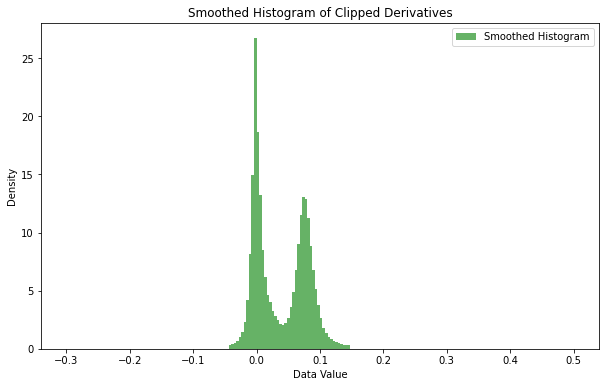

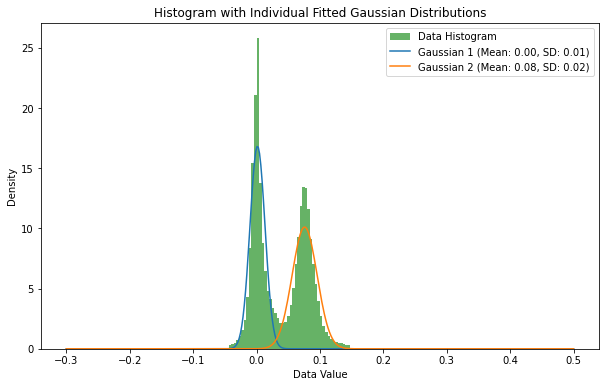

Returning means and standard deviations
Mean1: 0.0014951935220843804 Stddev1: 0.01186499038767199
Mean2: 0.0757998893002837 Stddev2: 0.019681809664652026
Classify and colour version 2
Red mean: 0.0014951935220843804  Red stddev: 0.01186499038767199
Green mean: 0.0757998893002837  Green stddev: 0.019681809664652026
K value: 3
includes undecided


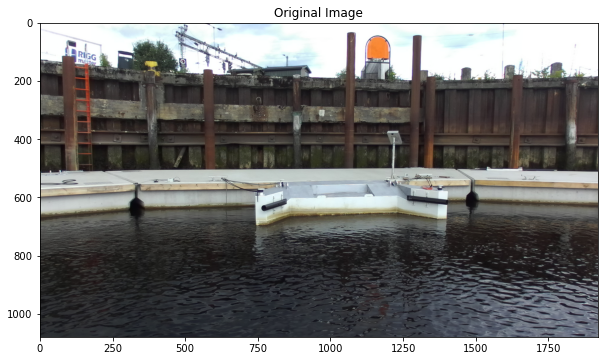

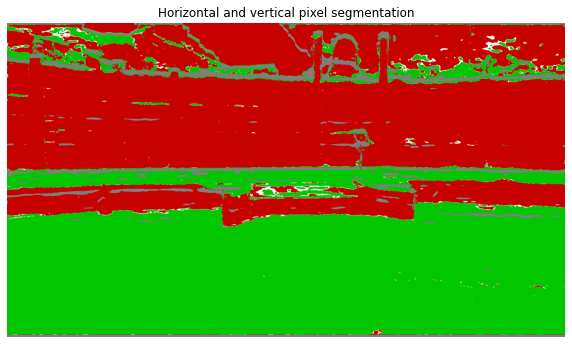

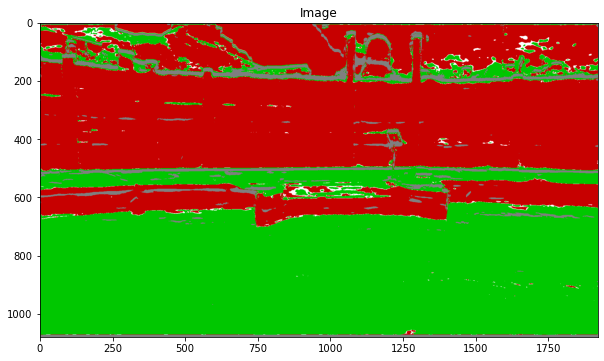

In [8]:
clustering = False
k_value = 3

# Interpolate
dI = interpolate_each_column(dI)

# Low-pass filter
df = apply_low_pass_filter(dI)

# Take the derivative
#df_derivative = take_derivative_diff(df)
#df_derivative = take_derivative_sobel(df, normalize=False)
#df_derivative = take_derivative_sobel(df)
df_derivative = take_derivative_diff(df)

# Flatten the derivatives for clustering
flattened_derivatives = flatten_and_plot_histogram(df_derivative, plot=False, title="Histogram of the derivatives")

# Clustering method
if(clustering):
    print("Clustering method")
    clustering_model, clipped_derivatives, labels, centers = clustering(flattened_derivatives)
    plot_clusters(clustering_model, labels)
    red_dL,red_dU, green_dL, green_dU = cluster_threshold_method(clustering_model, labels, clipped_derivatives, k=k_value, plot=True)
    classification_map = classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU)


# Gaussian mixtures method
else:
    print("Gaussian mixtures method")
    #red_dL, red_dU, green_dL, green_dU = thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=2, num_bins=200,p=0.01, k=2.5, plot=True)
    #classification_map = classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU)

    mean1, mean2, stddev1, stddev2 = thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=2, num_bins=200,p=0.01, k=k_value, plot=True, version=2)
    classification_map = classify_points(df_derivative, mean1, mean2, stddev1, stddev2, k=k_value)


# Original image
display_disp_image(original_image, title="Original Image")

# Plot colorized image
colored_image = assign_colours_and_plot(classification_map, title="Horizontal and vertical pixel segmentation")

display_disp_image(colored_image)

### Dividing the points into lists

In [9]:

def split_into_lists(surface_splitting_disparity_image, get_columns=True, print_numbers=True):
    if(print_numbers):
        print("Splitting into lists")
        vertCount = 0
        horCount = 0
        noneCount = 0

    # Verticals
    vertical_Derivative_List = []
    vertical_Disp_List = []
    vertical_Obj_List = []

    divided_vertical_obj_list = []


    #Horizonals
    horizontal_Derivative_List = []
    horizontal_Disp_List = []
    horizontal_Obj_List = []

    divided_horizontal_obj_list = []

    if(get_columns):
        for j in range(classification_map.shape[1]):  # Rows 1080

            single_col_hor_obj_list = []
            single_col_vert_obj_list = []
            for i in range(classification_map.shape[0]):  # Columns 1920

                current_local_value = classification_map[i, j]

                if(current_local_value == 'vertical'):
                    vertCount += 1
                    vertical_Derivative_List.append(df_derivative[i,j])
                    appendObjectVert = [surface_splitting_disparity_image[i, j], i, j, 'vertical']
                    vertical_Disp_List.append(surface_splitting_disparity_image[i,j])
                    vertical_Obj_List.append(appendObjectVert)
                    single_col_vert_obj_list.append(appendObjectVert)

                
                
                
                elif(current_local_value == 'horizontal'):
                    horCount += 1
                    der_val = df_derivative[i, j]
                    horizontal_Derivative_List.append(der_val)
                    # Object = [Disparity value, vertical derivative value, i coordinate, j coordinate, label]
                    appendObjectHor = [surface_splitting_disparity_image[i, j], der_val, i, j, 'horizontal']
                    horizontal_Disp_List.append(surface_splitting_disparity_image[i,j])
                    horizontal_Obj_List.append(appendObjectHor)
                    single_col_hor_obj_list.append(appendObjectHor)

                else:
                    noneCount+=1
            divided_vertical_obj_list.append(single_col_vert_obj_list)
            divided_horizontal_obj_list.append(single_col_hor_obj_list)

    else:
        for i in range(classification_map.shape[0]):  # Rows 1080

            single_col_hor_obj_list = []
            single_col_vert_obj_list = []
            for j in range(classification_map.shape[1]):  # Columns 1920

                current_local_value = classification_map[i, j]

                if(current_local_value == 'vertical'):
                    vertCount += 1
                    vertical_Derivative_List.append(df_derivative[i,j])
                    appendObjectVert = [surface_splitting_disparity_image[i, j], i, j, 'vertical']
                    vertical_Disp_List.append(surface_splitting_disparity_image[i,j])
                    vertical_Obj_List.append(appendObjectVert)
                    single_col_vert_obj_list.append(appendObjectVert)

                
                
                
                elif(current_local_value == 'horizontal'):
                    horCount += 1
                    der_val = df_derivative[i, j]
                    horizontal_Derivative_List.append(der_val)
                    # Object = [Disparity value, vertical derivative value, i coordinate, j coordinate, label]
                    appendObjectHor = [surface_splitting_disparity_image[i, j], der_val, i, j, 'horizontal']
                    horizontal_Disp_List.append(surface_splitting_disparity_image[i,j])
                    horizontal_Obj_List.append(appendObjectHor)
                    single_col_hor_obj_list.append(appendObjectHor)

                else:
                    noneCount+=1
            divided_vertical_obj_list.append(single_col_vert_obj_list)
            divided_horizontal_obj_list.append(single_col_hor_obj_list)

    if(print_numbers):
        print("verticals: ", vertCount)
        print("Horizontals: ", horCount)
        print("Unknown: ", noneCount)
        print("[Disparity Value, Derivative Value, V index, U index, Label]")
    
    verticals = (vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list)
    horizontals =(horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list)

    return verticals, horizontals

# ----------------------------------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------------------------

surface_split_disparity_image = dI

verticals, horizontals = split_into_lists(surface_split_disparity_image)

vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals
horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list = horizontals


print(len(vertical_Obj_List))
print(len(horizontal_Obj_List))

Splitting into lists
verticals:  976034
Horizontals:  966936
Unknown:  130630
[Disparity Value, Derivative Value, V index, U index, Label]
976034
966936


In [16]:
i = 730
print("Horizontals: ", len(divided_horizontal_obj_list[i]))
print("Verticals: ",len(divided_vertical_obj_list[i]))

print("Disparity Value, Derivative Value, V index(row), U index)column), Label")
print(divided_horizontal_obj_list[i][0])

def single_column_disparities(col_object_list, i):

    current_col = col_object_list[i]

    column_disparities = []
    for obj in current_col:
        disp = obj[0]
        column_disparities.append(disp)

    return column_disparities



vert_col_disp_i = single_column_disparities(divided_vertical_obj_list, i)
hor_col_disp_i = single_column_disparities(divided_horizontal_obj_list, i)

#for i in hor_col_disp_i:
#    print(i)

Horizontals:  515
Verticals:  485
Disparity Value, Derivative Value, V index(row), U index)column), Label
[0.0, 0.036072884, 124, 730, 'horizontal']


In [28]:

def divided_vertical_disps(col_object_list):
    all_vertical_disps = []

    for col in range(len(col_object_list)):
        current_col = single_column_disparities(col_object_list, col)
        all_vertical_disps.append(current_col)

    return all_vertical_disps

def display_histogram(data, input_bins=200, input_range=(0,60)):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=input_bins,  range=input_range, alpha=0.6, label='Histogram', density=True)
    plt.title('Histogram of Disparity Values of Vertical labeled points')
    plt.xlabel('Disparity Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

from scipy.signal import find_peaks

def plot_histogram_with_peaks(data, bins=200, min_prominence=0.01, min_distance=1, auto_range=(-1,60), plot=True):

    # Ensure data is cleaned
    #data = np.array(data)
    #data = data[np.isfinite(data)]


    hist, bin_edges = np.histogram(data,range=auto_range, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for plotting

    # Find peaks with adjusted parameters
    peaks, properties = find_peaks(hist, prominence=min_prominence, distance=min_distance)

    if(plot):
        # Plotting the histogram and peaks
        plt.figure(figsize=(10, 6))
        plt.hist(data, bins=bins,  range=auto_range, alpha=0.6, label='Histogram', density=True)
        plt.plot(bin_centers, hist, label='Histogram Line')
        plt.scatter(bin_centers[peaks], hist[peaks],color='red', s=100, zorder=5, label='Peaks/Modes')
        plt.title('Cluster Data and Detected Modes')
        plt.xlabel('Disparity')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

    # Print peak bin centers
    peak_values = bin_centers[peaks]
    print("Detected modes at:", peak_values)
    return peak_values


all_vertical_disps = divided_vertical_disps(divided_vertical_obj_list)

In [21]:
print("Length:  ", len(all_vertical_disps))
print(all_vertical_disps[i])

Length:   1920
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.828125, 4.8632812, 11.609375, 11.660156, 11.667969, 11.660156, 11.65625, 11.660156, 11.652344, 11.65625, 11.65625, 11.65625, 11.644531, 11.640625, 11.640625, 11.636719, 11.636719, 11.621094, 11.597656, 11.597656, 11.59375, 11.582031, 11.578125, 11.5625, 11.542969, 11.542969, 11.542969, 11.527344, 11.472656, 11.425781, 11.3828125, 11.355469, 11.34375, 11.363281

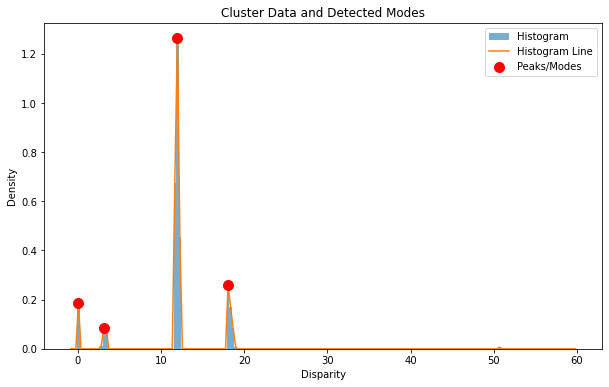

Detected modes at: [ 0.0675     3.1174998 11.9625    18.0625   ]


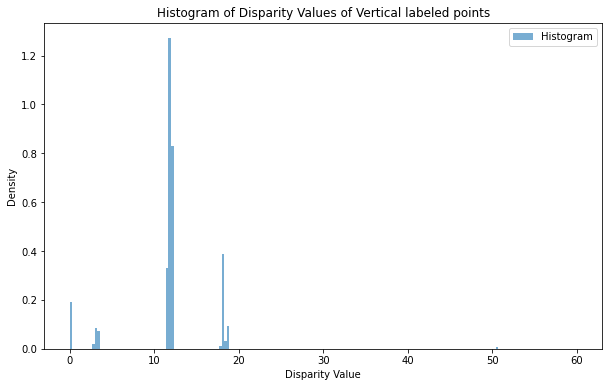

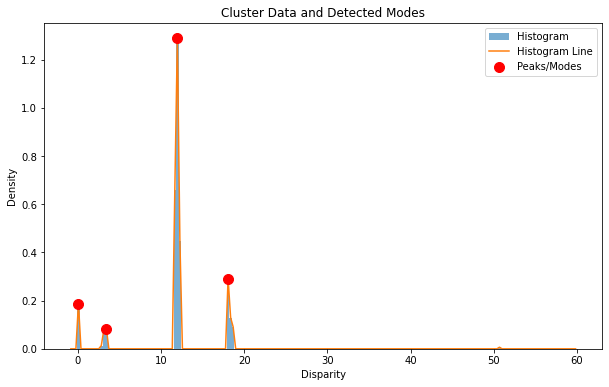

Detected modes at: [ 0.0675     3.4225001 11.9625    18.0625   ]


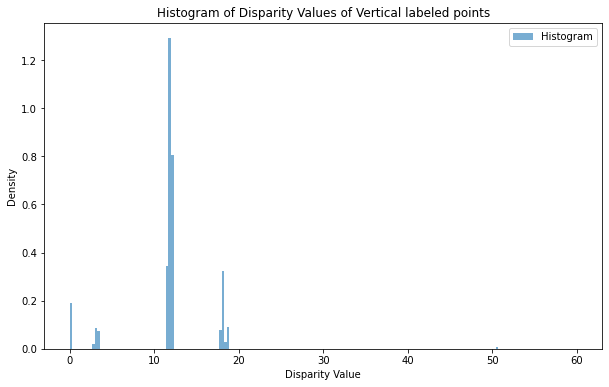

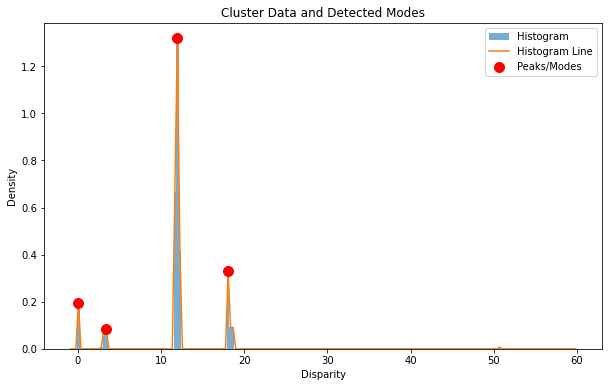

Detected modes at: [ 0.0675     3.4225001 11.9625    18.0625   ]


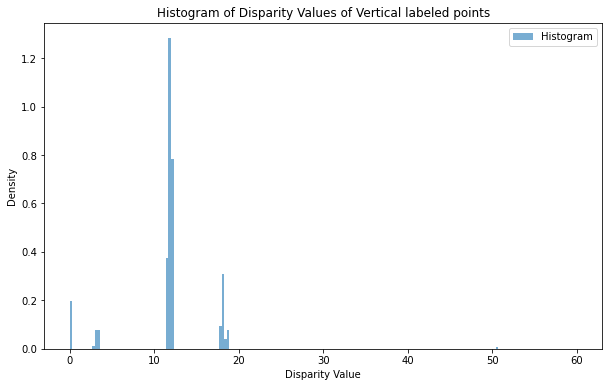

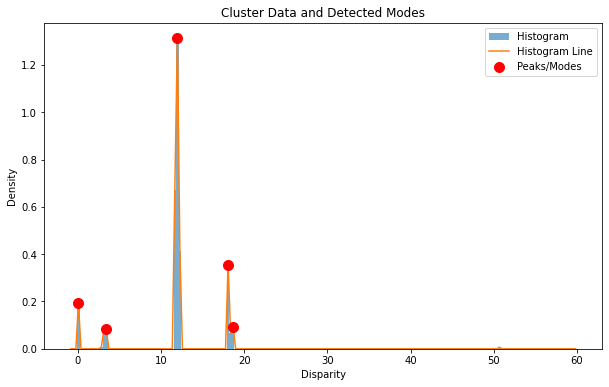

Detected modes at: [ 0.0675     3.4225001 11.9625    18.0625    18.6725   ]


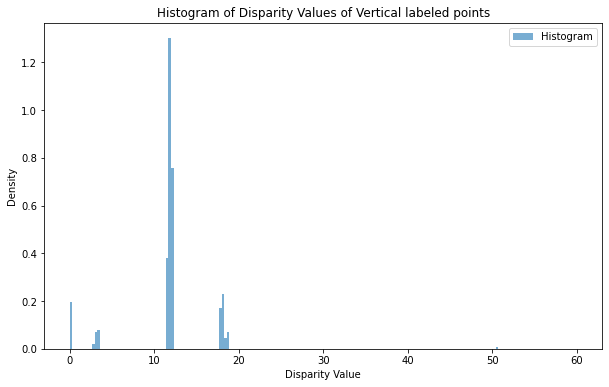

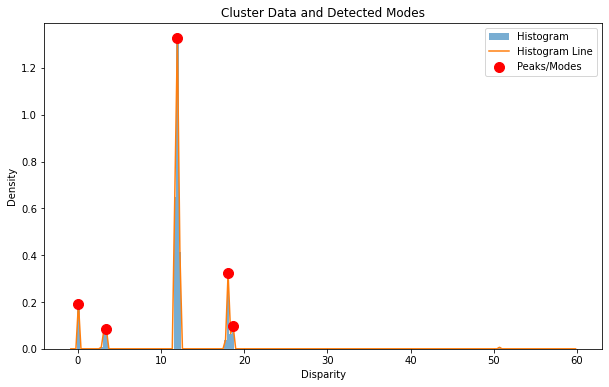

Detected modes at: [ 0.0675     3.4225001 11.9625    18.0625    18.6725   ]


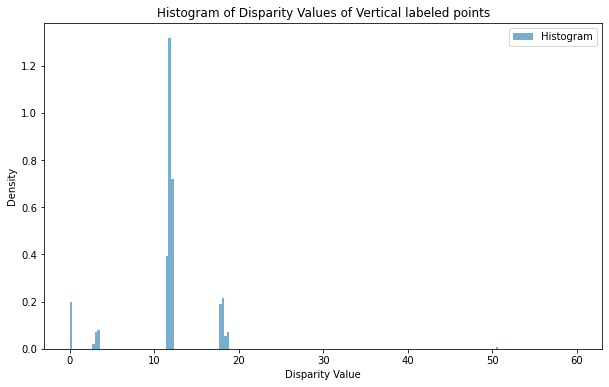

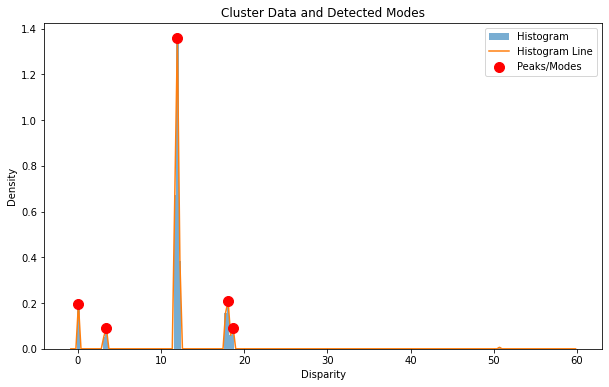

Detected modes at: [ 0.0675     3.4225001 11.9625    18.0625    18.6725   ]


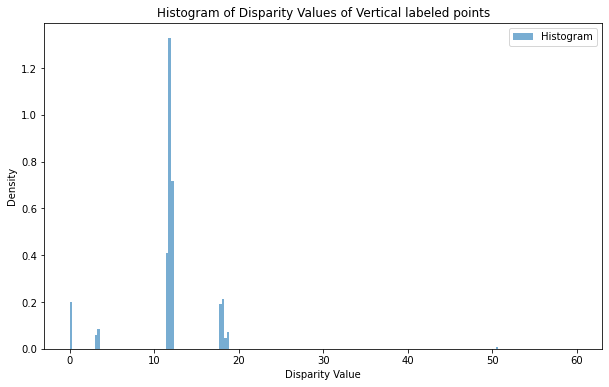

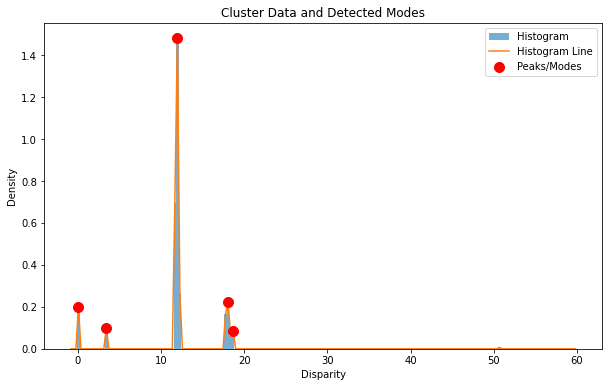

Detected modes at: [ 0.0675     3.4225001 11.9625    18.0625    18.6725   ]


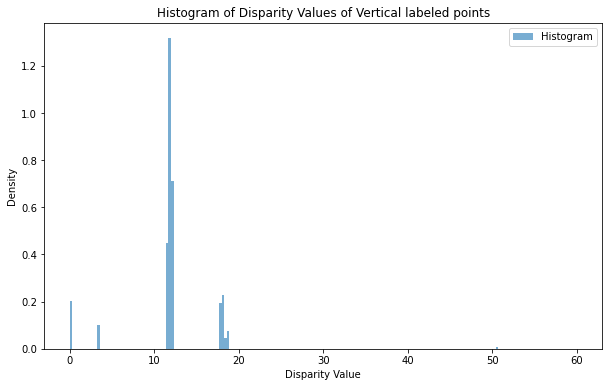

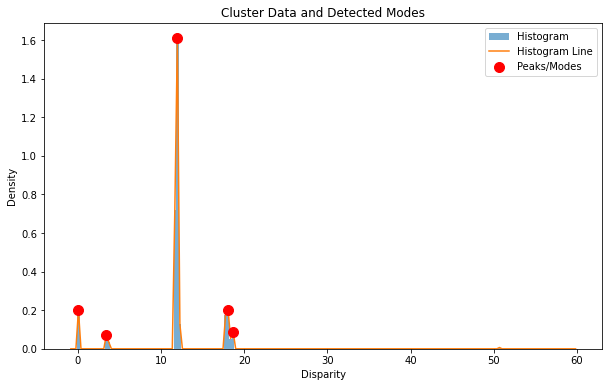

Detected modes at: [ 0.0675     3.4225001 11.9625    18.0625    18.6725   ]


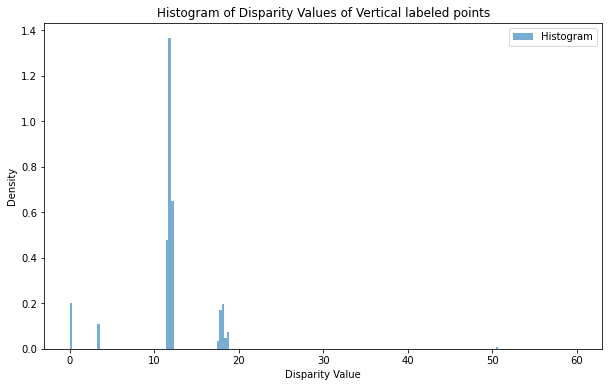

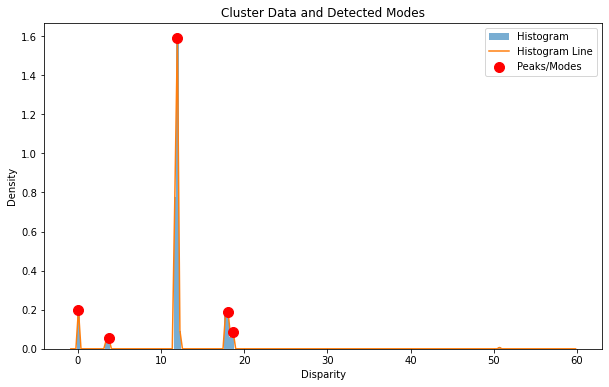

Detected modes at: [ 0.0675  3.7275 11.9625 18.0625 18.6725]


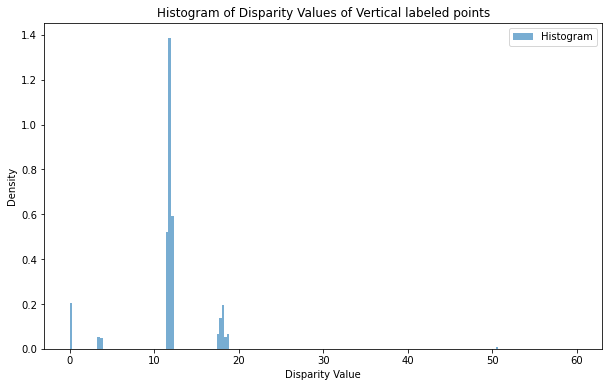

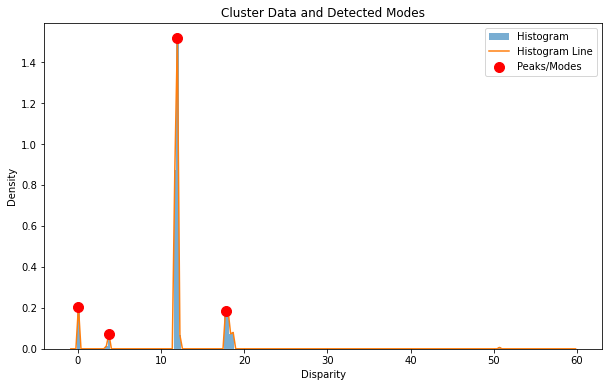

Detected modes at: [ 0.0675  3.7275 11.9625 17.7575]


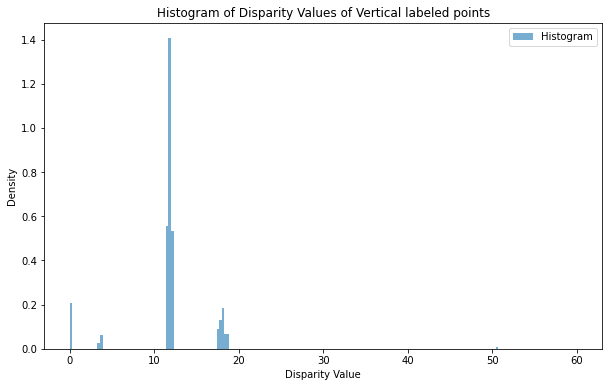

In [30]:
num_bins = 200
for i in range(305, 315):
    plot_histogram_with_peaks(all_vertical_disps[i], bins=num_bins, min_prominence=0.01, min_distance=1)
    display_histogram(all_vertical_disps[i], input_bins=num_bins)

## Kladding for vertikal segmentering

## Gammel kladd under

In [11]:
""" import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Assuming 'flattened_derivatives' is your dataset
# flattened_derivatives = ...

# Step 1: Clip the data between -0.2 and 0.4
clipped_derivatives = np.clip(flattened_derivatives, -0.2, 0.4)

# Step 2: Fit a Gaussian Mixture Model with 2 components to the clipped data
gmm = GaussianMixture(n_components=4, random_state=0)
gmm.fit(clipped_derivatives.reshape(-1, 1))

# Step 3: Extract the means and standard deviations of the fitted Gaussians
means = gmm.means_.flatten()
std_devs = np.sqrt(gmm.covariances_).flatten()

# Print the extracted parameters
print("Gaussian 1: Mean =", means[0], ", Standard Deviation =", std_devs[0])
print("Gaussian 2: Mean =", means[1], ", Standard Deviation =", std_devs[1])

# Optional: Plot the histogram of the clipped data and the fitted Gaussian PDFs
# Create a range of values for plotting the Gaussians
x_values = np.linspace(-0.1, 0.3, 400)
gmm_pdf = np.exp(gmm.score_samples(x_values.reshape(-1, 1)))

# Plot the histogram of the clipped data
plt.figure(figsize=(10, 6))
plt.hist(clipped_derivatives, bins=200, density=True, alpha=0.6, color='g', label='Data Histogram')

# Plot the overall PDF of the two Gaussians
plt.plot(x_values, gmm_pdf, label='Fitted Gaussians', color='red')
plt.legend()
plt.title('Histogram with Fitted Gaussian Distributions on Clipped Data')
plt.xlabel('Data Value')
plt.ylabel('Density')

plt.show()
 """

 

' import numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.mixture import GaussianMixture\n\n# Assuming \'flattened_derivatives\' is your dataset\n# flattened_derivatives = ...\n\n# Step 1: Clip the data between -0.2 and 0.4\nclipped_derivatives = np.clip(flattened_derivatives, -0.2, 0.4)\n\n# Step 2: Fit a Gaussian Mixture Model with 2 components to the clipped data\ngmm = GaussianMixture(n_components=4, random_state=0)\ngmm.fit(clipped_derivatives.reshape(-1, 1))\n\n# Step 3: Extract the means and standard deviations of the fitted Gaussians\nmeans = gmm.means_.flatten()\nstd_devs = np.sqrt(gmm.covariances_).flatten()\n\n# Print the extracted parameters\nprint("Gaussian 1: Mean =", means[0], ", Standard Deviation =", std_devs[0])\nprint("Gaussian 2: Mean =", means[1], ", Standard Deviation =", std_devs[1])\n\n# Optional: Plot the histogram of the clipped data and the fitted Gaussian PDFs\n# Create a range of values for plotting the Gaussians\nx_values = np.linspace(-0.1, 0.3,